# Node-based learning

## Imports and setup

In [1]:
import os
import sys

sys.path.append(os.getcwd())
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import networkx as nx
from sklearn.metrics import roc_curve, auc
import numpy as np
import data_utils
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef

%matplotlib inline

In [2]:
fn_coauthors = "ca-HepPh.txt.gz"
df_coauthors = (
    data_utils.load_dataset_from_web(fn_coauthors)
    .rename(columns={0: "source", 1: "target"})
    .astype(str)
)
df_coauthors

,source,target
0,17010,1943
1,17010,2489
2,17010,3426
3,17010,4049
4,17010,16961
...,...,...
237005,71913,45004
237006,71913,77145
237007,42800,74899
237008,87816,5319


## Introduction

In [3]:
g = nx.from_pandas_edgelist(df_coauthors, "source", "target")
print(
    f"The raw graph has {g.number_of_nodes():,} nodes and {g.number_of_edges():,} edges"
)
g = data_utils.get_connected_component_subgraphs(g)[0]
print(
    f"The largest connected component that has {g.number_of_nodes():,} nodes and {g.number_of_edges():,} edges"
)

The raw graph has 12,008 nodes and 118,521 edges
The largest connected component that has 11,204 nodes and 117,649 edges


Text(0.5, 0.98, 'Log-log plot of the degree distribution\n(the full dataset)')

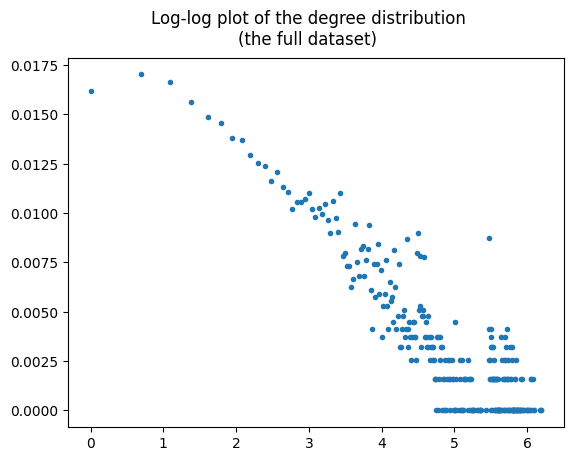

In [4]:
# log-log plot of the degree distribution
fig, ax = plt.subplots()
log_degrees = np.log(np.array([d for n, d in g.degree]))
log_counts = np.log(pd.Series(log_degrees).value_counts().sort_index())
log_freq = log_counts / log_counts.sum()
ax.plot(log_counts.index, log_freq, ".")
fig.suptitle("Log-log plot of the degree distribution\n(the full dataset)")

For demonstration purposes, we will use very small percentage of the edges.

The raw graph has 2,481 nodes and 2,362 edges
We are taking the largest connected component that has 977 nodes and 1,470 edges


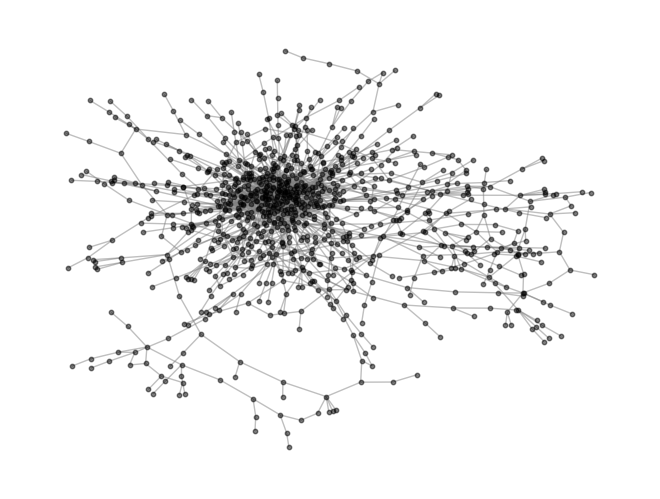

In [5]:
df_sample = df_coauthors.sample(frac=0.01, random_state=42)
g = nx.from_pandas_edgelist(df_sample, "source", "target")
print(
    f"The raw graph has {g.number_of_nodes():,} nodes and {g.number_of_edges():,} edges"
)
g = data_utils.get_connected_component_subgraphs(g)[0]
layout = nx.spring_layout(g)
nx.draw(g, layout, node_size=10, node_color="black", edge_color="gray", alpha=0.5)
print(
    f"We are taking the largest connected component that has {g.number_of_nodes():,} nodes and {g.number_of_edges():,} edges"
)

Text(0.5, 0.98, 'Log-log plot of the degree distribution\n(the 1-percent edge sample)')

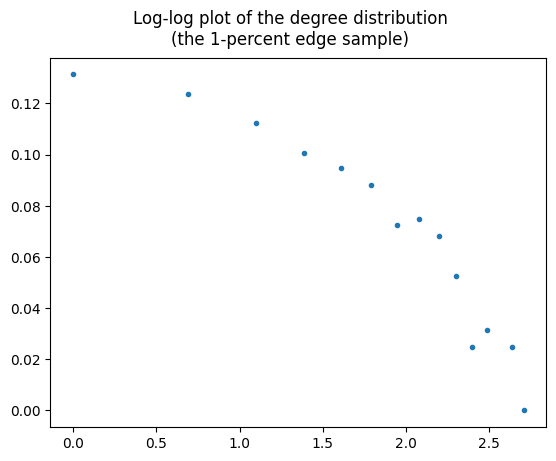

In [6]:
# log-log plot of the degree distribution
fig, ax = plt.subplots()
log_degrees = np.log(np.array([d for n, d in g.degree]))
log_counts = np.log(pd.Series(log_degrees).value_counts().sort_index())
log_freq = log_counts / log_counts.sum()
ax.plot(log_counts.index, log_freq, ".")
fig.suptitle("Log-log plot of the degree distribution\n(the 1-percent edge sample)")

The graph that we have here is a graph of co-authorship relationships. The nodes are authors, and the edges are co-authorship relationships. This graph was build by parsing author names from the abstract text, which may itroduce some ambiguity, mainly due to the fact that the same author may be referred to in different ways ("Gorelik B vs. Gorelik Boris"). Also, many authors may have the same name, which may lead to the same name being used for different authors. 

The dataset that we have is anonymous, we will simulate the latter form of ambiguity by scrambling some of the nodes

In [7]:
# now, we will introduce some abiguity in the graph
np.random.seed(42)
all_author_ids = set(df_coauthors["source"]).union(set(df_coauthors["target"]))
frac_noise = 0.005
n_noise = int(frac_noise * len(all_author_ids))

scrambled = dict()

for i in range(n_noise):
    n_to_scramble = np.random.randint(2, 4)
    scrambled_name = f"scrambled_{i:02d}"
    nodes_to_scramble = []
    while len(nodes_to_scramble) < n_to_scramble:
        node = np.random.choice(list(all_author_ids))
        if node not in scrambled:
            scrambled[node] = scrambled_name
            nodes_to_scramble.append(node)
print(f"Scrambled {len(scrambled):,} nodes")

Scrambled 151 nodes


In [8]:
df_scrambled = df_sample.copy()
df_scrambled["source"] = df_scrambled["source"].apply(lambda x: scrambled.get(x, x))
df_scrambled["target"] = df_scrambled["target"].apply(lambda x: scrambled.get(x, x))
g_scrambled = nx.from_pandas_edgelist(df_scrambled, "source", "target")
# add `scrambled` attribute to the nodes
for node in g_scrambled.nodes:
    g_scrambled.nodes[node]["scrambled"] = node.startswith("scrambled")
g_scrambled = data_utils.get_connected_component_subgraphs(g_scrambled)[0]
print(
    f"The largest connected component that has {g_scrambled.number_of_nodes():,} nodes and {g_scrambled.number_of_edges():,} edges"
)

The largest connected component that has 988 nodes and 1,482 edges


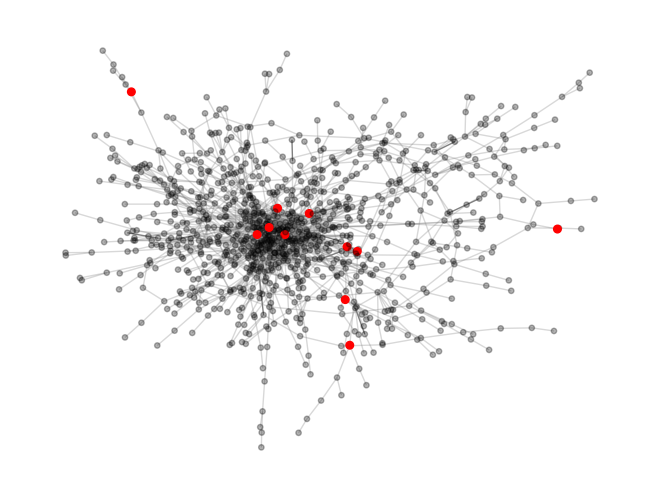

In [9]:
layout = nx.spring_layout(g_scrambled)
node_colors = [
    "red" if g_scrambled.nodes[n]["scrambled"] else "black" for n in g_scrambled.nodes
]
node_sizes = [
    30 if g_scrambled.nodes[n]["scrambled"] else 15 for n in g_scrambled.nodes
]
node_opacity = [
    1 if g_scrambled.nodes[n]["scrambled"] else 0.3 for n in g_scrambled.nodes
]
nx.draw(
    g_scrambled,
    layout,
    node_size=node_sizes,
    node_color=node_colors,
    edge_color="gray",
    alpha=node_opacity,
)
nx.write_graphml(g_scrambled, "/Users/boris/temp/graph_scrambled.graphml")

## Building a classifier to distinguish between the original and the scrambled nodes

To build a classifier that can distinguish between the original and the scrambled nodes, we will use the following features:
- the degree of the node
- the clustering coefficient of the node
- the number of triangles the node is part of
- the number of triangles the node is part of that are not part of any other triangle
- node centrality measures: betweenness, closeness, eigenvector


In [10]:
def compute_node_features(g) -> pd.DataFrame:
    # approx 2 minutes of computation time on the full dataset
    degrees = dict(g.degree)
    clustering = nx.clustering(g)
    triangles = nx.triangles(g)
    triangles_no_others = dict()
    n_depth_2 = dict()
    n_depth_4 = dict()
    for node in tqdm(g.nodes, total=len(g.nodes), leave=False):
        triangles_no_others[node] = sum(
            [1 for n in g.neighbors(node) if n in triangles and triangles[n] == 1]
        )
        n_depth_2[node] = len(
            set(nx.single_source_shortest_path_length(g, node, cutoff=2))
        )
        n_depth_4[node] = len(
            set(nx.single_source_shortest_path_length(g, node, cutoff=4))
        )
    ret = pd.DataFrame(
        {
            "degree": degrees,
            "clustering": clustering,
            "triangles": triangles,
            "triangles_no_others": triangles_no_others,
            "n_depth_2": n_depth_2,
            "n_depth_4": n_depth_4,
        }
    )
    return ret


df_node_features = compute_node_features(g_scrambled)

  0%|          | 0/988 [00:00<?, ?it/s]

### Centrality features

Node centrality is a measure of the importance or influence of a node within a network. There are several types of centrality measures, such as:

- **Degree Centrality**: The number of direct connections a node has.
- **Closeness Centrality**: How close a node is to all other nodes in the network.
- **Betweenness Centrality**: The number of times a node acts as a bridge along the shortest path between two other nodes.
- **Eigenvector Centrality**: The influence of a node based on the influence of its neighbors.
- **Katz Centrality**: A measure that considers the number of all paths that lead to a node, attenuated by the length of the paths.
- **PageRank**: A measure that evaluates the importance of nodes based on the structure of incoming links.
- **HITS (Hubs and Authorities)**: Identifies two types of nodes: hubs, which point to many nodes, and authorities, which are pointed to by many hubs.
- **Clustering Coefficient**: The degree to which nodes tend to cluster together.


Note, that some of these metrics can be very computationally expensive, especially when computed directly, without any approximation heuristics.  


Look at the description of the betweenness centrality. It is a logical assumption that a node that represents multiple actual authors will have a higher betweenness centrality than a node that represents a single author. This is because the former will be part of many shortest paths between other nodes, while the latter will be part of fewer shortest paths. For the same reason, the closeness centrality of a node that represents multiple authors will be lower than the closeness centrality of a node that represents a single author.


In [11]:
def compute_centrality_features(g) -> pd.DataFrame:
    # approx 8 minutes of computation time on the full dataset.
    # 1 minute on a 1-percent edge sample
    betweenness_centrality = nx.betweenness_centrality(g)
    closeness_centrality = nx.closeness_centrality(g)
    ret = pd.DataFrame(
        {
            "betweenness_centrality": betweenness_centrality,
            "closeness_centrality": closeness_centrality,
            "katz": nx.katz_centrality(g),
        }
    )
    return ret


df_centrality_features = compute_centrality_features(g_scrambled)

### Community features

We may think of a community as a group of nodes that are more connected to each other than to the rest of the network. Community detection is the process of identifying these groups of nodes. These algorithms rely on various parameters such as resolution and are stochastic in their nature. Thus, we may assume that if a single node represents multiple authors, it is more likely that its community assignment will be stronger influenced by the changes in parameters. 


A good reading on community detection algorithms can be found here: https://memgraph.com/blog/community-detection-algorithms-with-python-networkx


#### Louvain community detection algorithm

We will use Louvain community detection algorithm to detect communities in the graph. The Louvain algorithm is a popular community detection algorithm that optimizes **Modularity**.
 
Modularity is a measure of the quality of a partition of a network into communities. It compares the number of edges within a community to the expected number of edges in a random network with the same degree distribution. The Louvain algorithm is based on the concept of modularity optimization, which is a measure of the quality of a partition of a network into communities. 

The algorithm works by iteratively optimizing the modularity of the network by moving nodes between communities.  The **resolution** parameter of the Louvain algorithm controls the trade-off between the size of the communities and the number of communities. A larger resolution parameter will result in fewer, larger communities, while a smaller resolution parameter will result in more, smaller communities.

  0%|          | 0/4 [00:00<?, ?it/s]

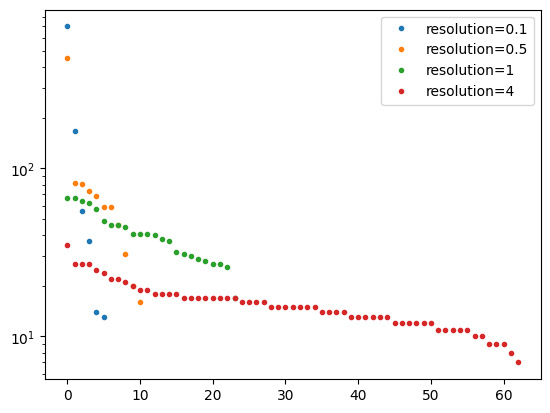

In [12]:
# community detection using louvain algorithm
fig, ax = plt.subplots()
for res in tqdm([0.1, 0.5, 1, 4]):
    communities = nx.community.louvain_communities(g_scrambled, resolution=res)
    sizes = [len(c) for c in communities]
    sizes.sort(key=lambda x: -x)
    ax.plot(range(len(sizes)), sizes, ".", label=f"resolution={res}")
    # assign `community_{res}` attribute to the nodes
    for i, c in enumerate(communities):
        for n in c:
            g_scrambled.nodes[n][
                f"community_{res:.2f}"
            ] = f"community@{res:.2f}_{i:03d}"
ax.legend()
ax.set_yscale("log")

What we see is that the larger the `resolution` parameter of the Louvain algorithm, the larger the communities that are detected. This is because the resolution parameter controls the trade-off between the size of the communities and the number of communities. A larger resolution parameter will result in fewer, larger communities, while a smaller resolution parameter will result in more, smaller communities.


We will use this use this information to count the fraction of neighbors that are in the same community as the node itself. We expect that scrambled nodes will have a lower fraction of neighbors in the same community.
 

We will repeat this for different values of the resolution parameter and use this as a feature for the classifier.

In [13]:
def compute_community_features(g) -> pd.DataFrame:
    # about 1 minute of computation time
    resolutions = np.round(np.linspace(0.01, 4, 10), 2)
    for res in tqdm(resolutions):
        communities = nx.community.louvain_communities(g, resolution=res)
        sizes = [len(c) for c in communities]
        sizes.sort(key=lambda x: -x)
        # assign `community_{res}` attribute to the nodes
        for i, c in enumerate(communities):
            for n in c:
                g.nodes[n][f"community_{res:.2f}"] = f"community@{res:.2f}_{i:03d}"

    ret = []
    for n in g.nodes:
        neighbors = set(g.neighbors(n))
        curr = {"node_id": n}
        for res in resolutions:
            community_this = g.nodes[n][f"community_{res:.2f}"]
            neighbors_in_community = [
                g.nodes[nb][f"community_{res:.2f}"] == community_this
                for nb in neighbors
            ]
            neighboring_communities = set(
                [g.nodes[nb][f"community_{res:.2f}"] for nb in neighbors]
            )
            n_neighboring_communities = len(neighboring_communities)
            curr[f"same_community@{res:.2f}"] = sum(neighbors_in_community) / len(
                neighbors
            )
            curr[f"n_neighboring_communities@{res:.2f}"] = n_neighboring_communities
        ret.append(curr)
    df_community_features = pd.DataFrame(ret).set_index("node_id")
    cols_same = [c for c in df_community_features.columns if "same_community" in c]
    cols_neighboring = [
        c for c in df_community_features.columns if "n_neighboring" in c
    ]
    mean_same = df_community_features[cols_same].mean(axis=1)
    mean_neighboring = df_community_features[cols_neighboring].mean(axis=1)
    df_community_features["mean_same"] = mean_same
    df_community_features["mean_neighboring"] = mean_neighboring
    for perc in [10, 25, 75, 90]:
        df_community_features[f"percentile_same_{perc}"] = df_community_features[
            cols_same
        ].apply(lambda x: np.percentile(x, perc), axis=1)
        df_community_features[f"percentile_neighboring_{perc}"] = df_community_features[
            cols_neighboring
        ].apply(lambda x: np.percentile(x, perc), axis=1)

    return df_community_features


df_community_features = compute_community_features(g_scrambled)
df_community_features

  0%|          | 0/10 [00:00<?, ?it/s]

,same_community@0.01,n_neighboring_communities@0.01,same_community@0.45,n_neighboring_communities@0.45,same_community@0.90,n_neighboring_communities@0.90,same_community@1.34,n_neighboring_communities@1.34,same_community@1.78,n_neighboring_communities@1.78,...,mean_same,mean_neighboring,percentile_same_10,percentile_neighboring_10,percentile_same_25,percentile_neighboring_25,percentile_same_75,percentile_neighboring_75,percentile_same_90,percentile_neighboring_90
node_id,,,,,,,,,,,,,,,,,,,,,
12011,1.0,1,1.000000,1,1.000000,1,0.5,2,1.0,1,...,0.800000,1.4,0.500000,1.0,0.500000,1.00,1.0,2.0,1.00,2.0
83889,1.0,1,1.000000,1,1.000000,1,1.0,1,1.0,1,...,1.000000,1.0,1.000000,1.0,1.000000,1.00,1.0,1.0,1.00,1.0
69494,1.0,1,1.000000,1,1.000000,1,1.0,1,1.0,1,...,1.000000,1.0,1.000000,1.0,1.000000,1.00,1.0,1.0,1.00,1.0
23517,1.0,1,1.000000,1,1.000000,1,1.0,1,1.0,1,...,1.000000,1.0,1.000000,1.0,1.000000,1.00,1.0,1.0,1.00,1.0
84171,1.0,1,0.866667,3,0.333333,9,0.4,8,0.4,9,...,0.433333,8.1,0.266667,2.8,0.266667,8.25,0.4,10.0,0.88,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88898,1.0,1,1.000000,1,1.000000,1,1.0,1,1.0,1,...,1.000000,1.0,1.000000,1.0,1.000000,1.00,1.0,1.0,1.00,1.0
15419,1.0,1,1.000000,1,0.600000,2,0.4,4,0.4,4,...,0.580000,2.8,0.400000,1.0,0.400000,2.00,0.6,4.0,1.00,4.0
70201,1.0,1,1.000000,1,1.000000,1,1.0,1,1.0,1,...,1.000000,1.0,1.000000,1.0,1.000000,1.00,1.0,1.0,1.00,1.0


### Ego-graph related features

An **ego graph** is a subgraph that includes a central node and all of its neighbors. Ego graphs are useful for analyzing the local structure of a network around a specific node. Sometimes it is intersting to examine the effect of removing the central node from the ego graph. We may assume that the effect of such a removal is stronger for nodes that represent multiple authors, than for nodes that represent a single author.

In the most obvious case, when a scrambled node connects two unrelated parts of a graph, removing it will disconnect the graph. But other, more subtle effects are possible, such as changes in the clustering coefficient, the diameter of the graph, or the number of connected components.

In [14]:
def compute_ego_graph_features(g):
    vals = []
    for n in tqdm(g.nodes, desc="Ego-related features", total=len(g.nodes)):
        ego = nx.ego_graph(g, n, radius=1)
        ego_no_self = ego.copy()
        ego_no_self.remove_node(n)

        curr = dict(node_id=n)
        betweenness_ego = nx.betweenness_centrality(ego)
        curr["betweenness_ego"] = betweenness_ego[n]
        closeness_ego = nx.closeness_centrality(ego)
        curr["closeness_ego"] = closeness_ego[n]
        clustering_before = nx.average_clustering(ego)
        clustering_after = nx.average_clustering(ego_no_self)
        curr["delta_clustering_ego"] = clustering_after - clustering_before

        diameter_before = nx.diameter(ego)

        try:
            diameter_after = nx.diameter(ego_no_self)
        except nx.NetworkXError:
            # if the graph is not connected, the diameter is infinite
            # we'll set it to the number of nodes + 1
            diameter_after = len(ego_no_self.nodes) + 1

        curr["delta_diameter_ego"] = diameter_after - diameter_before

        curr["n_components_no_self_ego"] = nx.number_connected_components(ego_no_self)
        density_before = nx.density(ego)
        density_after = nx.density(ego_no_self)
        curr["delta_density_ego"] = density_after - density_before
        vals.append(curr)
    return pd.DataFrame(vals).set_index("node_id")


df_egograph_features = compute_ego_graph_features(g_scrambled)

Ego-related features:   0%|          | 0/988 [00:00<?, ?it/s]

### Supervised learning

Now, we have computed the features that we will use to build a classifier that can distinguish between the original and the scrambled nodes. We will use the following features:

In [15]:
df_all = pd.concat(
    [df_egograph_features, df_centrality_features, df_community_features], axis=1
)
for i in range(10):
    df_all[f"rnd_{i}"] = np.random.rand(len(df_all))

y = np.array(["scrambled" in i for i in df_community_features.index])
print(f"{df_all.shape=}, {y.mean()=:.3f}")

df_all.shape=(988, 49), y.mean()=0.011


Our dataset is highly imbalanced. To force the classifier to pay more attention to the minority class, we will use sample weights. We will set the sample weight to 100 for the minority class and 1 for the majority class.

In [16]:
weights = np.ones_like(y, dtype=float)
weights[y] = 100

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_all, y, weights, test_size=0.2, random_state=42
)

# Initialize the CatBoost classifier
classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=1e-4,
    depth=8,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=150,  # Early stopping
    l2_leaf_reg=10,  # L2 regularization
    subsample=0.8,  # Subsample fraction
    verbose=True,
)
# Fit the model with sample weights
classifier.fit(
    X_train, y_train, sample_weight=weights_train, eval_set=(X_test, y_test), plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.1505102	best: 0.1505102 (0)	total: 61.5ms	remaining: 1m 1s
1:	test: 0.1186224	best: 0.1505102 (0)	total: 64.6ms	remaining: 32.2s
2:	test: 0.1875000	best: 0.1875000 (2)	total: 70.2ms	remaining: 23.3s
3:	test: 0.1619898	best: 0.1875000 (2)	total: 74.1ms	remaining: 18.5s
4:	test: 0.2053571	best: 0.2053571 (4)	total: 76.8ms	remaining: 15.3s
5:	test: 0.2321429	best: 0.2321429 (5)	total: 79.7ms	remaining: 13.2s
6:	test: 0.2857143	best: 0.2857143 (6)	total: 82.3ms	remaining: 11.7s
7:	test: 0.3035714	best: 0.3035714 (7)	total: 85.1ms	remaining: 10.5s
8:	test: 0.2244898	best: 0.3035714 (7)	total: 88.9ms	remaining: 9.79s
9:	test: 0.2525510	best: 0.3035714 (7)	total: 92.2ms	remaining: 9.13s
10:	test: 0.2372449	best: 0.3035714 (7)	total: 95.3ms	remaining: 8.57s
11:	test: 0.1734694	best: 0.3035714 (7)	total: 97.8ms	remaining: 8.05s
12:	test: 0.1913265	best: 0.3035714 (7)	total: 100ms	remaining: 7.62s
13:	test: 0.1658163	best: 0.3035714 (7)	total: 104ms	remaining: 7.3s
14:	test: 0.1377551

In [18]:
def show_prediction_performance(X_test, y_test, classifier):
    # Predict and evaluate if needed
    y_pred = classifier.predict(X_test)
    p_pred_proba = classifier.predict_proba(X_test)[:, 1]
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews correlation coefficient: {mcc:.2f}")
    precision = 100 * np.sum(y_test & y_pred) / np.sum(y_pred)
    recall = 100 * np.sum(y_test & y_pred) / np.sum(y_test)
    print(
        f"Of the {y_pred.sum():3,d} nodes predicted as scrambled,      {precision:.1f}% are actually scrambled"
    )
    print(
        f"Of the {y_test.sum():,d}  nodes that are actually scrambled, {recall:.1f}% are predicted as scrambled"
    )

    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(9, 6), height_ratios=[5, 1], width_ratios=[5, 4]
    )
    ax = axes[0, 0]
    # roc curve
    fpr, tpr, _ = roc_curve(y_test, p_pred_proba)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle="--")
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
    auc_score = auc(fpr, tpr)
    ax.set_title(f"AUC: {auc_score:.2f}", va="top")

    ax = axes[1, 0]
    lix = np.argsort(p_pred_proba)
    ax.plot(p_pred_proba[lix], ".", ms=0.5)
    y_test_sorted = y_test[lix]
    for i in range(len(y_test_sorted)):
        if y_test_sorted[i]:
            ax.axvline(i, color="red", alpha=0.4)
    ax.axhline(0.5, color="black", linestyle="--")

    ax = axes[0, 1]
    # feature importance
    try:
        feature_importance = (
            classifier.get_feature_importance(prettified=True).head(10).iloc[::-1]
        )
        feature_importance.plot.barh(
            x="Feature Id", y="Importances", legend=False, ax=ax
        )
        ax.set_ylabel("")
        ax.set_xlabel("Feature Importance")
    except:
        ax.axis("off")

    ax = axes[1, 1]
    # turn off
    ax.axis("off")
    fig.tight_layout()

Matthews correlation coefficient: -0.01
Of the   2 nodes predicted as scrambled,      0.0% are actually scrambled
Of the 2  nodes that are actually scrambled, 0.0% are predicted as scrambled


Text(0.5, 1.02, 'Prediction performance on the partial dataset')

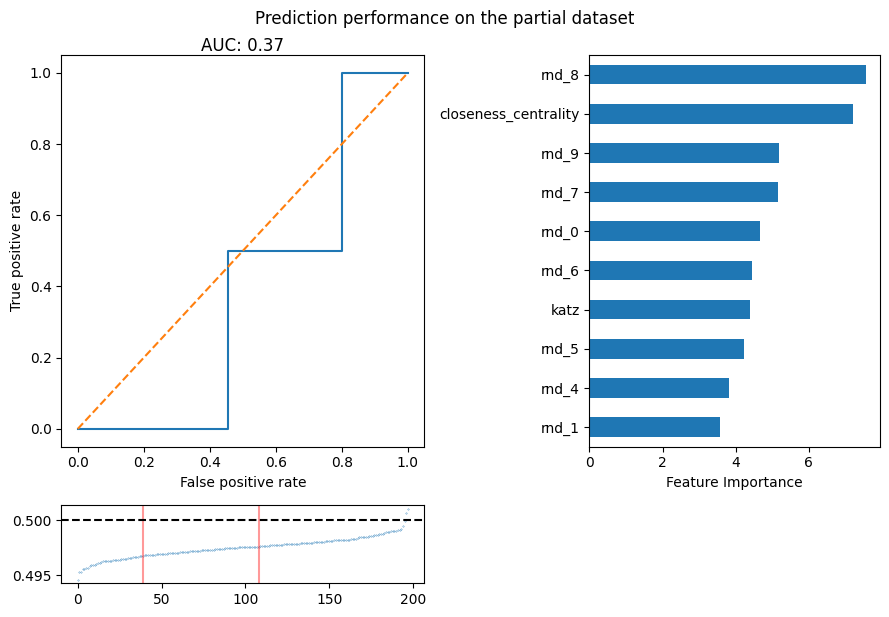

In [19]:
show_prediction_performance(X_test, y_test, classifier)
fig = plt.gcf()
fig.suptitle("Prediction performance on the partial dataset", y=1.02)

### Analyzing the full dataset
Now, let's load the full dataset

In [20]:
df_full = data_utils.load_dataset_from_local("df_node_disambiguation_task").set_index(
    "node_id", drop=True
)
for i in range(10):
    df_full[f"rnd_{i}"] = np.random.rand(len(df_full))
df_full.shape

(11917, 48)

In [21]:
y = np.array(["scrambled" in i for i in df_full.index])
weights = np.ones_like(y, dtype=float)
weights[y] = 100
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_full, y, weights, test_size=0.2, random_state=42
)
classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=1e-5,
    depth=12,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=150,  # Early stopping
    l2_leaf_reg=10,  # L2 regularization
    subsample=0.8,  # Subsample fraction
    verbose=True,
)
classifier.fit(
    X_train, y_train, sample_weight=weights_train, eval_set=(X_test, y_test), plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7606226	best: 0.7606226 (0)	total: 97.1ms	remaining: 1m 36s
1:	test: 0.8250796	best: 0.8250796 (1)	total: 181ms	remaining: 1m 30s
2:	test: 0.8178677	best: 0.8250796 (1)	total: 243ms	remaining: 1m 20s
3:	test: 0.8075906	best: 0.8250796 (1)	total: 296ms	remaining: 1m 13s
4:	test: 0.8093335	best: 0.8250796 (1)	total: 298ms	remaining: 59.4s
5:	test: 0.8083118	best: 0.8250796 (1)	total: 366ms	remaining: 1m
6:	test: 0.8018210	best: 0.8250796 (1)	total: 424ms	remaining: 1m
7:	test: 0.8141415	best: 0.8250796 (1)	total: 484ms	remaining: 1m
8:	test: 0.7909129	best: 0.8250796 (1)	total: 544ms	remaining: 60s
9:	test: 0.7924755	best: 0.8250796 (1)	total: 611ms	remaining: 1m
10:	test: 0.8068995	best: 0.8250796 (1)	total: 671ms	remaining: 1m
11:	test: 0.8035339	best: 0.8250796 (1)	total: 722ms	remaining: 59.5s
12:	test: 0.8117675	best: 0.8250796 (1)	total: 784ms	remaining: 59.5s
13:	test: 0.8200613	best: 0.8250796 (1)	total: 841ms	remaining: 59.2s
14:	test: 0.8207825	best: 0.8250796 (1)	to

Matthews correlation coefficient: 0.07
Of the  94 nodes predicted as scrambled,      2.1% are actually scrambled
Of the 7  nodes that are actually scrambled, 28.6% are predicted as scrambled


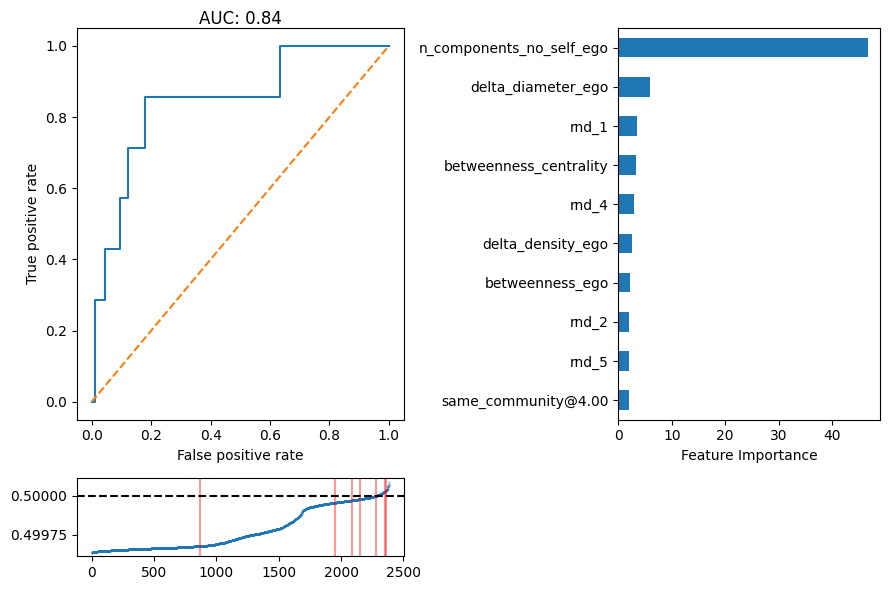

In [22]:
show_prediction_performance(X_test, y_test, classifier)

In [23]:
cols_to_take = [
    "n_components_no_self_ego",
    "delta_diameter_ego",
    "betweenness_centrality",
    "betweenness_ego",
    "delta_clustering_ego",
]
for c in cols_to_take:
    assert c in df_full.columns

In [24]:
y = np.array(["scrambled" in i for i in df_full.index])
weights = np.ones_like(y, dtype=float)
weights[y] = 100
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    df_full[cols_to_take], y, weights, test_size=0.2, random_state=42
)
classifier = CatBoostClassifier(
    iterations=1000,
    learning_rate=1e-5,
    depth=12,
    loss_function="Logloss",
    eval_metric="AUC",
    early_stopping_rounds=150,  # Early stopping
    l2_leaf_reg=10,  # L2 regularization
    subsample=0.8,  # Subsample fraction
    verbose=True,
)
classifier.fit(
    X_train, y_train, sample_weight=weights_train, eval_set=(X_test, y_test), plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7967726	best: 0.7967726 (0)	total: 15.7ms	remaining: 15.7s
1:	test: 0.7956908	best: 0.7967726 (0)	total: 34.5ms	remaining: 17.2s
2:	test: 0.8160647	best: 0.8160647 (2)	total: 50.2ms	remaining: 16.7s
3:	test: 0.8178677	best: 0.8178677 (3)	total: 73.3ms	remaining: 18.2s
4:	test: 0.8240579	best: 0.8240579 (4)	total: 94.5ms	remaining: 18.8s
5:	test: 0.8221948	best: 0.8240579 (4)	total: 106ms	remaining: 17.6s
6:	test: 0.8242082	best: 0.8242082 (6)	total: 123ms	remaining: 17.4s
7:	test: 0.8228559	best: 0.8242082 (6)	total: 139ms	remaining: 17.2s
8:	test: 0.8171164	best: 0.8242082 (6)	total: 152ms	remaining: 16.7s
9:	test: 0.8191598	best: 0.8242082 (6)	total: 164ms	remaining: 16.3s
10:	test: 0.8200613	best: 0.8242082 (6)	total: 176ms	remaining: 15.8s
11:	test: 0.8249895	best: 0.8249895 (11)	total: 189ms	remaining: 15.5s
12:	test: 0.8195204	best: 0.8249895 (11)	total: 199ms	remaining: 15.1s
13:	test: 0.8219845	best: 0.8249895 (11)	total: 208ms	remaining: 14.6s
14:	test: 0.8233668	be

Matthews correlation coefficient: 0.10
Of the 266 nodes predicted as scrambled,      1.9% are actually scrambled
Of the 7  nodes that are actually scrambled, 71.4% are predicted as scrambled


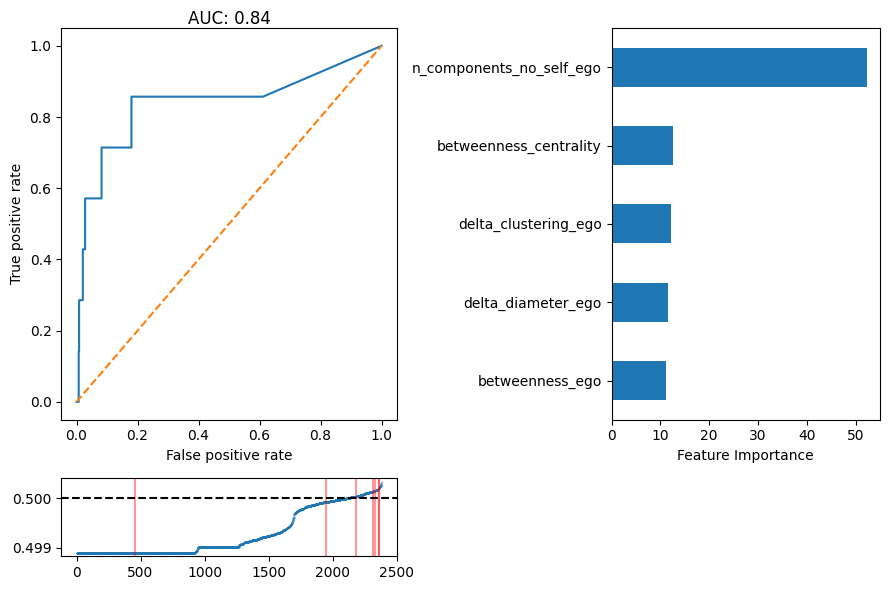

In [25]:
show_prediction_performance(X_test, y_test, classifier)

You might be unimpressed by the performance of the classifier. However, consider that the only informtion that the classifier has is the structure of the graph. The classifier does not know the names of the nodes, the content of the abstracts, or any other information that could be used to distinguish between the original and the scrambled nodes. The fact that the classifier can distinguish between the original and the scrambled nodes with an AUC of 0.85 is quite impressive.

Compare the performance of the classifier with the performance of a majority class classifier and a random classifier.

Matthews correlation coefficient: 0.00
Of the   0 nodes predicted as scrambled,      nan% are actually scrambled
Of the 7  nodes that are actually scrambled, 0.0% are predicted as scrambled
Matthews correlation coefficient: 0.00
Of the   0 nodes predicted as scrambled,      nan% are actually scrambled
Of the 7  nodes that are actually scrambled, 0.0% are predicted as scrambled


/var/folders/xy/6n3m38qx423b_gjbx89x02b40000gn/T/ipykernel_28176/572443355.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = 100 * np.sum(y_test & y_pred) / np.sum(y_pred)
/var/folders/xy/6n3m38qx423b_gjbx89x02b40000gn/T/ipykernel_28176/572443355.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = 100 * np.sum(y_test & y_pred) / np.sum(y_pred)


Text(0.5, 1.02, 'Random classifier')

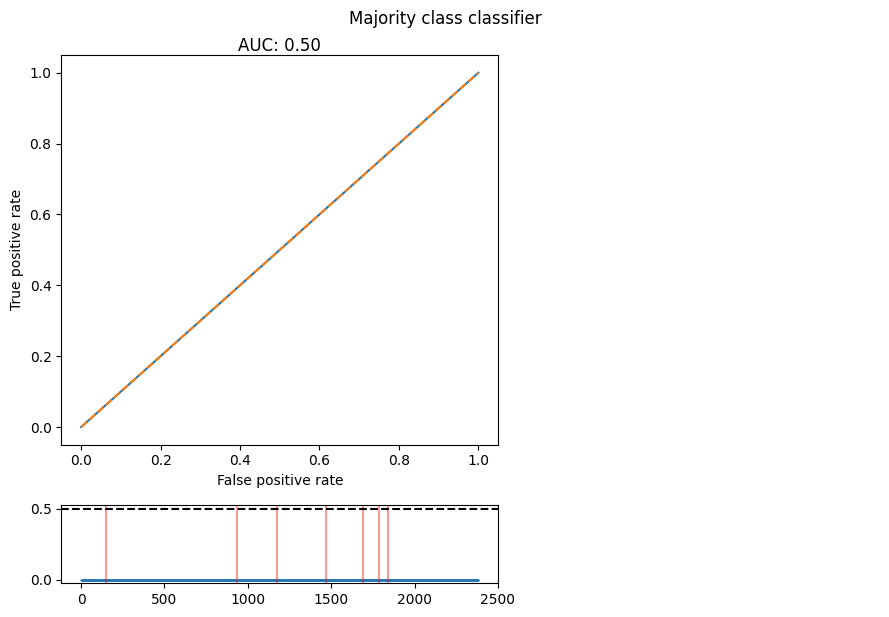

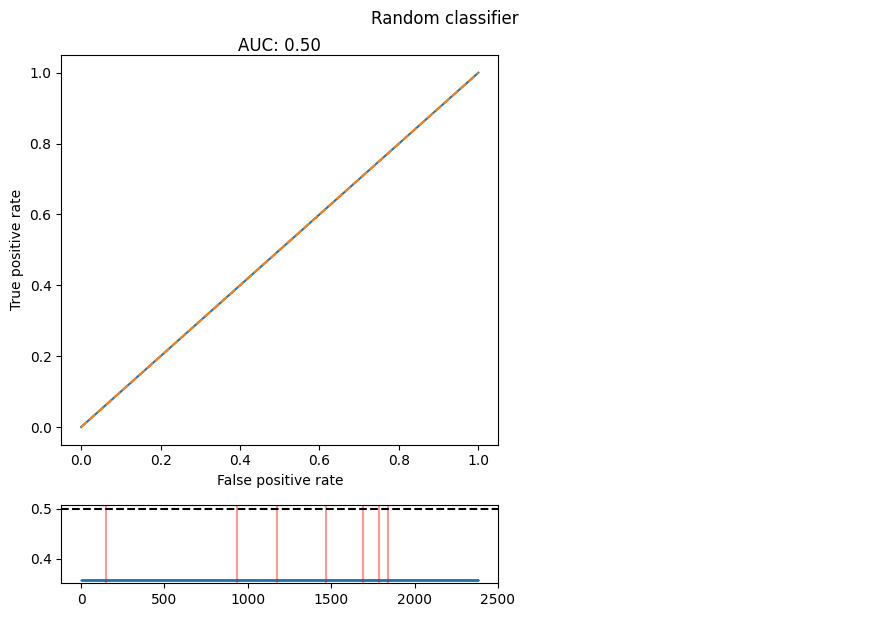

In [26]:
# for the purpose of performance comparison, we will use a majority class classifier and a random classifier
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train, sample_weight=weights_train)
show_prediction_performance(X_test, y_test, dummy)
fig = plt.gcf()
fig.suptitle("Majority class classifier", y=1.02)
dummy = DummyClassifier(strategy="prior")
dummy.fit(X_train, y_train, sample_weight=weights_train)
show_prediction_performance(X_test, y_test, dummy)
fig = plt.gcf()
fig.suptitle("Random classifier", y=1.02)

#### SHAP Values for Better Interpretability

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance. They are based on cooperative game theory and offer a way to explain the output of any machine learning model. SHAP values can be used to explain the prediction of any instance in terms of the contribution of each feature to the prediction.

SHAP values are computed by first considering all possible feature combinations and then calculating the contribution of each feature across these combinations. The values of the SHAP values represent the average contributions of the features to the prediction. SHAP values can be positive or negative, depending on whether the feature positively or negatively contributes to the prediction. The larger the absolute value of the SHAP value, the greater the feature's contribution to the prediction.

In [33]:
import shap

shap_values = shap.TreeExplainer(classifier)(X_test)

In [34]:
y_pred = classifier.predict_proba(X_test)[:, 1]
most_suspicious = np.argmax(y_pred)
print(f"Most suspicious node: {X_test.index[most_suspicious]}")

Most suspicious node: 18068


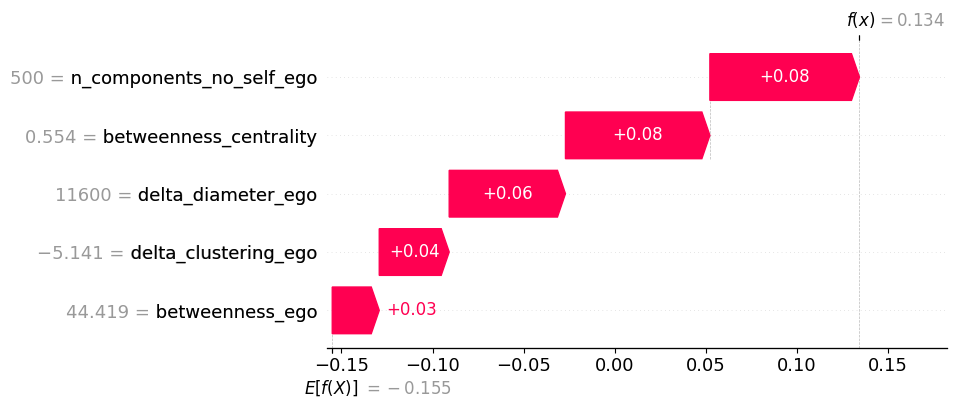

In [35]:
shap.plots.waterfall(shap_values[most_suspicious] * 100, max_display=10)

Less suspicious node: 58128


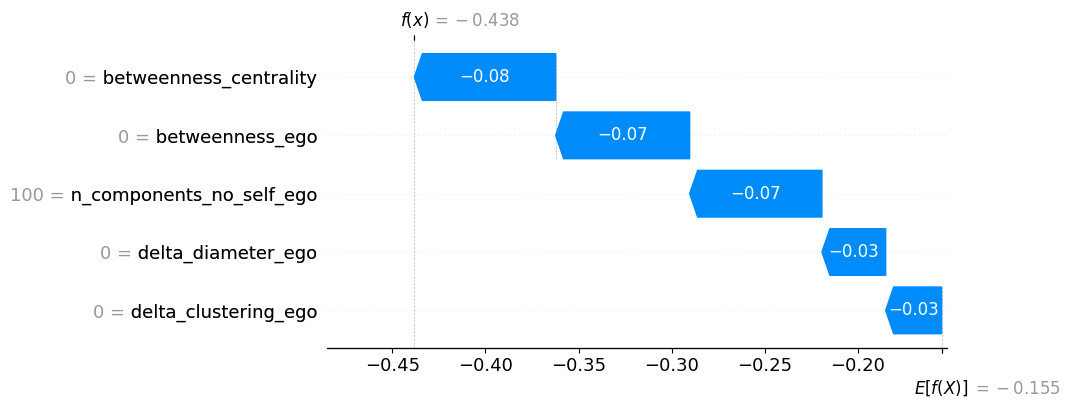

In [36]:
less_suspicious = np.argmin(y_pred)
print(f"Less suspicious node: {X_test.index[less_suspicious]}")
shap.plots.waterfall(shap_values[less_suspicious] * 100, max_display=10)

In [40]:
y_pred

array([0.49994206, 0.49890467, 0.49890467, ..., 0.49982863, 0.49986091,
       0.49890467])

Random node: 911


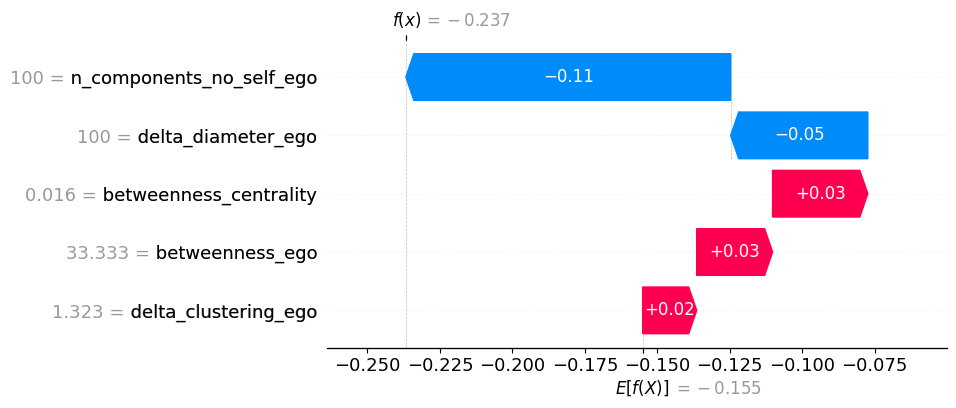

In [44]:
random_node = np.random.randint(len(y_pred))
print(f"Random node: {random_node}")
shap.plots.waterfall(shap_values[random_node] * 100, max_display=10)

We can plot shap values for the entire dataset to see the distribution of the feature importance.

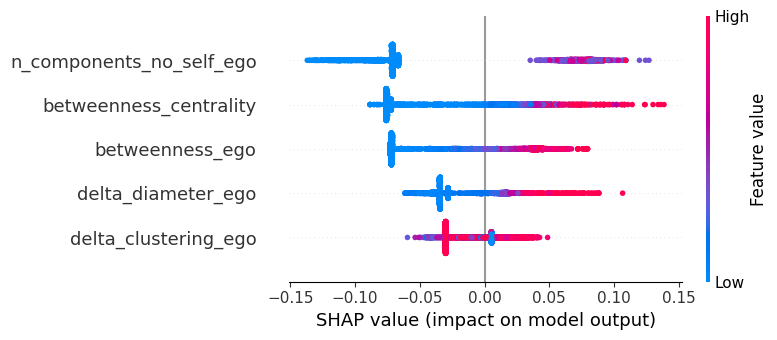

In [45]:
shap.summary_plot(shap_values * 100, X_test)